# Wald and Gamma Regression (Australian insurance claims 2004-2005)

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(1234)

## Load and examine Vehicle insurance data

In this notebook we use a data set consisting of 67856 insurance policies and 4624 (6.8%) claims in Australia between 2004 and 2005. The original source of this dataset is the book [Generalized Linear Models for Insurance Data](http://www.businessandeconomics.mq.edu.au/our_departments/Applied_Finance_and_Actuarial_Studies/research/books/GLMsforInsuranceData) by Piet de Jong and Gillian Z. Heller. 

In [3]:
data = pd.read_csv("data/carclaims.csv")
data.head()

,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0,0,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0,0,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0,0,0.0,UTE,2,F,E,2
3,4.14,0.317591,0,0,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0,0,0.0,HBACK,4,F,C,2


Let's see the meaning of the variables before creating any plot or fitting any model.

* **veh_value**: Vehicle value, ranges from \\$0 to \\$350,000.
* **exposure**: Proportion of the year where the policy was exposed. In practice each policy is not exposed for the full year. Some policies come into force partly into the year while others are canceled before the year’s end.
* **clm**: Claim occurrence. 0 (no), 1 (yes).
* **numclaims**: Number of claims.
* **claimcst0**: Claim amount. 0 if no claim. Ranges from \\$200 to \\$55922.
* **veh_body**: Vehicle body type. Can be one of bus, convertible, coupe, hatchback, hardtop, motorized caravan/combi, minibus, panel van, roadster, sedan, station wagon, truck, and utility.
* **veh_age**: Vehicle age. 1 (new), 2, 3, and 4.
* **gender**: Gender of the driver. M (Male) and F (Female).
* **area**: Driver's area of residence. Can be one of A, B, C, D, E, and F.
* **agecat**: Driver's age category. 1 (youngest), 2, 3, 4, 5, and 6.

The variable of interest is the claim amount, given by `"claimcst0"`. We keep the records where there is a claim, so claim amount is greater than 0. 

In [4]:
data = data[data["claimcst0"] > 0]

For clarity, we only show those claims amounts below \\$15,000, since there are only 65 records above that threshold.

In [5]:
data[data["claimcst0"] > 15000].shape[0]

65

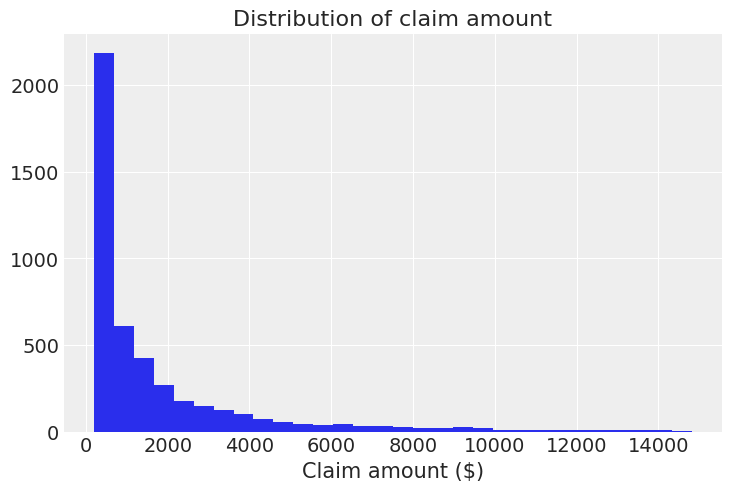

In [6]:
plt.hist(data[data["claimcst0"] <= 15000]["claimcst0"], bins=30)
plt.title("Distribution of claim amount")
plt.xlabel("Claim amount ($)");

And this is when you say: "Oh, there really are ugly right-skewed distributions out there!". Well, yes, we've all been there :) 

In this case we are going to fit GLMs with a right-skewed distribution for the random component. This time we will be using Wald and Gamma distributions. One of their differences is that the variance is proportional to the cubic mean in the case of the Wald distribution, and proportional to the squared mean in the case of the Gamma distribution.

## Wald family

The Wald family (a.k.a inverse Gaussian model) states that 

$$
\begin{array}{cc}
y_i \sim \text{Wald}(\mu_i, \lambda) & g(\mu_i) = \mathbf{x}_i^T\beta
\end{array}
$$

where the pdf of a Wald distribution is given by 

$$
f(x|\mu, \lambda) = 
\left(\frac{\lambda}{2\pi}\right)^{1/2}x^{-3/2}\exp\left\{ -\frac{\lambda}{2x} \left(\frac{x - \mu}{\mu} \right)^2 \right\}
$$

for $x > 0$, mean $\mu > 0$ and $\lambda > 0$ is the shape parameter. The variance is given by $\sigma^2 = \mu^3/\lambda$. The canonical link is $g(\mu_i) = \mu_i^{-2}$, but $g(\mu_i) = \log(\mu_i)$ is usually preferred, and it is what we use here.

## Gamma family

The default parametrization of the Gamma density function is 

$$
\displaystyle f(x | \alpha, \beta) = \frac{\beta^\alpha x^{\alpha -1} e^{-\beta x}}{\Gamma(\alpha)}
$$

where $x > 0$, and $\alpha > 0$ and $\beta > 0$ are the shape and rate parameters, respectively.

But GLMs model the mean of the function, so we need to use an alternative parametrization where 

$$
\begin{array}{ccc}
\displaystyle \mu = \frac{\alpha}{\beta} & \text{and} & \displaystyle \sigma^2 = \frac{\alpha}{\beta^2}
\end{array}
$$

and thus we have

$$
\begin{array}{cccc}
y_i \sim \text{Gamma}(\mu_i, \sigma_i), & g(\mu_i) = \mathbf{x}_i^T\beta, & \text{and} & \sigma_i = \mu_i^2/\alpha
\end{array}
$$

where $\alpha$ is the shape parameter in the original parametrization of the gamma pdf. The canonical link is $g(\mu_i) = \mu_i^{-1}$, but here we use $g(\mu_i) = \log(\mu_i)$ again.

## Model fit

In this example we are going to use the binned age, the gender, and the area of residence to predict the amount of the claim, conditional on the existence of the claim because we are only working with observations where there is a claim.

`"agecat"` is interpreted as a numeric variable in our data frame, but we know it is categorical, and we wouldn't be happy if our model takes it as if it was numeric, would we? 

We have two alternatives to tell Bambi that this numeric variable must be treated as categorical. The first one is to wrap the name of the variable with `C()`, and the other is to pass the same name to the categorical argument when we create the model. We are going to use the first approach with the Wald family and the second with the Gamma. 

The `C()` notation is taken from [Patsy](https://patsy.readthedocs.io/en/latest/index.html) and is encouraged when you want to explicitly pass the order of the levels of the variables. If you are happy with the default order, better pass the name to `categorical` so tables and plots have prettier labels :)

### Wald

In [7]:
model_wald = bmb.Model("claimcst0 ~ C(agecat) + gender + area", data, family = "wald", link = "log")
fitted_wald = model_wald.fit(tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [claimcst0_lam, area, gender, C(agecat), Intercept]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 24 seconds.


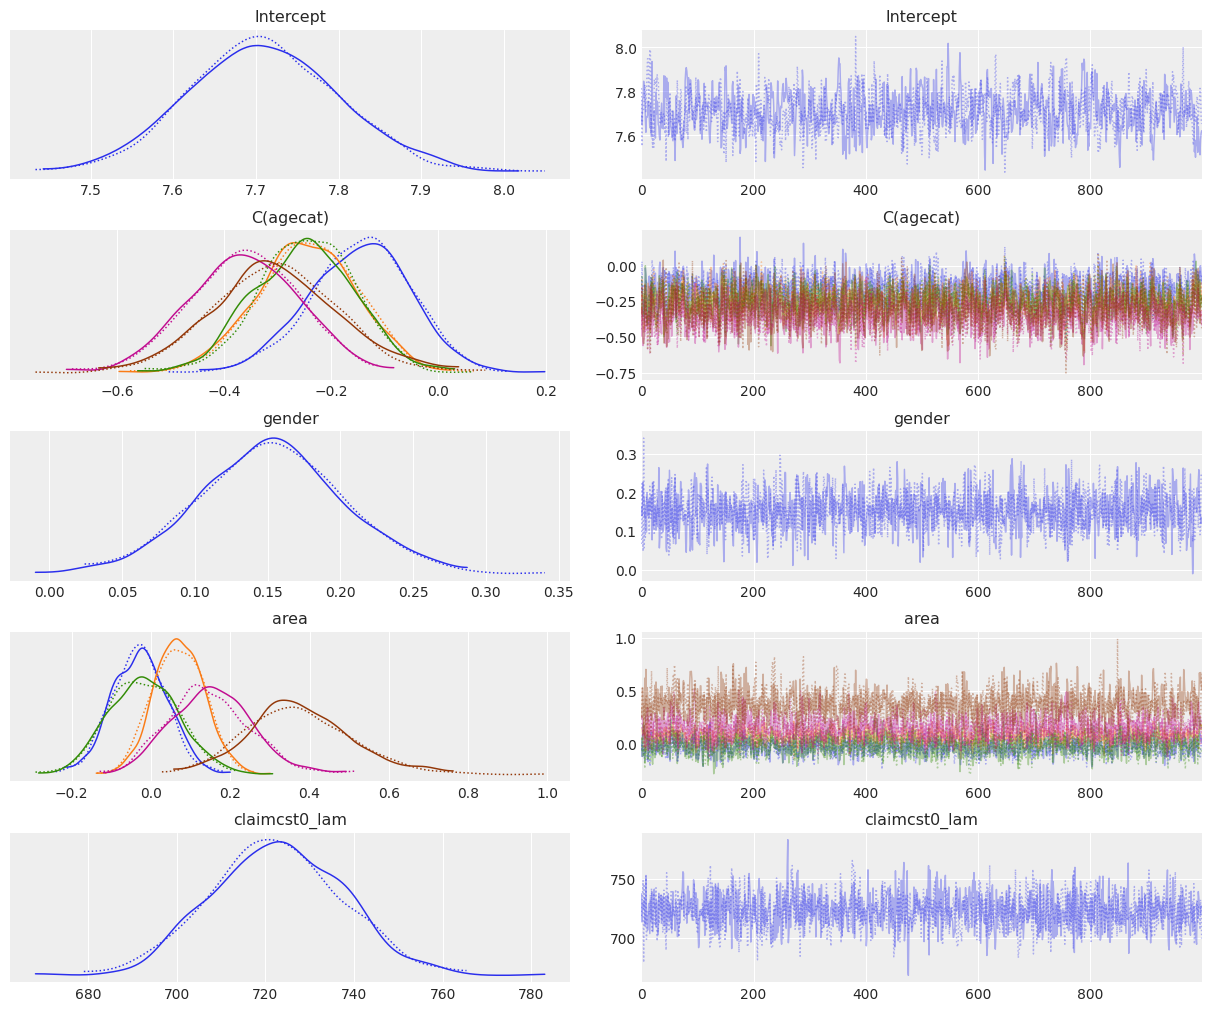

In [8]:
az.plot_trace(fitted_wald);

In [9]:
az.summary(fitted_wald)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,7.709,0.091,7.539,7.882,0.003,0.002,719.0,935.0,1.0
C(agecat)[2],-0.146,0.094,-0.325,0.026,0.003,0.002,1007.0,1159.0,1.0
C(agecat)[3],-0.245,0.093,-0.414,-0.069,0.003,0.002,883.0,1256.0,1.0
C(agecat)[4],-0.249,0.091,-0.409,-0.076,0.003,0.002,951.0,1085.0,1.0
C(agecat)[5],-0.364,0.101,-0.552,-0.180,0.003,0.002,1098.0,1373.0,1.0
C(agecat)[6],-0.305,0.118,-0.521,-0.074,0.004,0.003,1126.0,949.0,1.0
gender[M],0.152,0.049,0.062,0.246,0.001,0.001,2071.0,1457.0,1.0
area[B],-0.029,0.069,-0.151,0.105,0.002,0.001,1450.0,1550.0,1.0
area[C],0.071,0.063,-0.042,0.194,0.002,0.001,1446.0,1494.0,1.0
area[D],-0.018,0.087,-0.177,0.147,0.002,0.002,1321.0,1109.0,1.0


If we look at the `agecat` variable, we can see the log mean of the claim amount tends to decrease when the age of the person increases, with the exception of the last category where we can see a slight increase in the mean of the coefficient (-0.307 vs -0.365 of the previous category). However, these differences only represent a slight tendency because of the large overlap between the marginal posteriors for these coefficients (see overlayed density plots for `C(agecat)`.

The posterior for `gender` tells us that the claim amount tends to be larger for males than for females, with the mean being 0.153 and the credible interval ranging from 0.054 to 0.246. 

Finally, from the marginal posteriors for the areas, we can see that F is the only area that clearly stands out, with a higher mean claim amount than in the rest. Area E may also have a higher claim amount, but this difference with the other areas is not as evident as it happens with F.

### Gamma

In [10]:
model_gamma = bmb.Model(
    "claimcst0 ~ agecat + gender + area",
    data,
    family="gamma",
    link="log",
    categorical="agecat",
)
fitted_gamma = model_gamma.fit(tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [claimcst0_alpha, area, gender, agecat, Intercept]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 20 seconds.


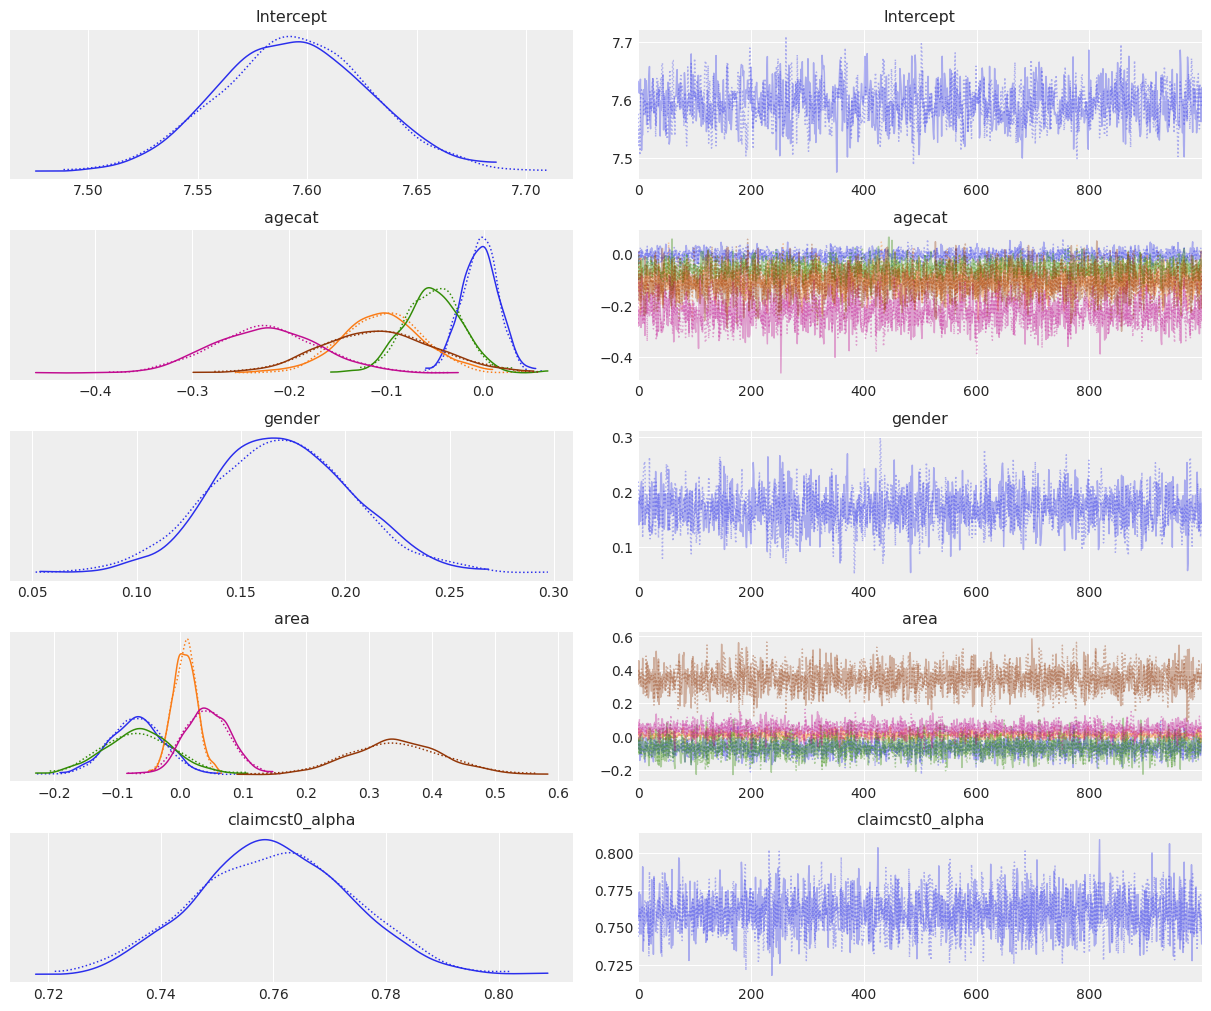

In [11]:
az.plot_trace(fitted_gamma);

In [12]:
az.summary(fitted_gamma)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,7.594,0.034,7.533,7.662,0.001,0.001,1057.0,1316.0,1.0
agecat[2],-0.004,0.019,-0.037,0.031,0.000,0.000,2378.0,1663.0,1.0
agecat[3],-0.104,0.042,-0.181,-0.025,0.001,0.001,1830.0,1827.0,1.0
agecat[4],-0.052,0.029,-0.106,0.000,0.001,0.000,1900.0,1419.0,1.0
agecat[5],-0.225,0.054,-0.327,-0.125,0.001,0.001,1723.0,1554.0,1.0
agecat[6],-0.109,0.057,-0.214,0.001,0.001,0.001,2399.0,1510.0,1.0
gender[M],0.169,0.034,0.105,0.234,0.001,0.001,1940.0,1504.0,1.0
area[B],-0.068,0.043,-0.150,0.010,0.001,0.001,2235.0,1687.0,1.0
area[C],0.008,0.019,-0.027,0.042,0.000,0.000,2808.0,1500.0,1.0
area[D],-0.065,0.056,-0.167,0.043,0.001,0.001,2601.0,1826.0,1.0


The interpretation of the parameter posteriors is very similar to what we've done for the Wald family. The only difference is that some differences, such as the ones for the area posteriors, are a little more exacerbated here.

## Model comparison

We can perform a Bayesian model comparison very easily with `az.compare()`. Here we pass a dictionary with the InferenceData objects that `Model.fit()` returned and `az.compare()` returns a data frame that is ordered from best to worst according to the criteria used. 

In [13]:
models = {"wald": fitted_wald, "gamma": fitted_gamma}
df_compare = az.compare(models)
df_compare

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
wald,0,-38580.934567,12.407292,0.000000,1.0,106.029487,0.000000,False,log
gamma,1,-39632.191931,19.696584,1051.257364,0.0,104.204977,34.598798,False,log


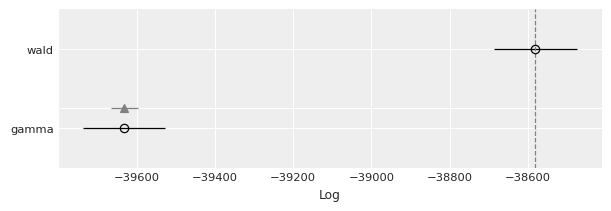

In [14]:
az.plot_compare(df_compare, insample_dev=False);

By default, ArviZ uses _loo_, which is an estimation of leave one out cross-validation. Another option is the widely applicable information criterion (WAIC). Since the results are in the log scale, the better out-of-sample predictive fit is given by the model with the highest value, which is the Wald model.

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Jun 15 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

bambi     : 0.5.0
numpy     : 1.20.1
json      : 2.0.9
pandas    : 1.2.2
arviz     : 0.11.2
matplotlib: 3.3.3

Watermark: 2.1.0

